Importing necessary libraries

In [37]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D, Input, MaxPool2D, Conv2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

Image fetching and image generator

In [38]:
data = ImageDataGenerator()

train_dir = r'C:\Users\Kevin\Desktop\S7\ANN\project\dataset\train'
val_dir = r'C:\Users\Kevin\Desktop\S7\ANN\project\dataset\validation'
test_dir = r'C:\Users\Kevin\Desktop\S7\ANN\project\dataset\test'

train_data = data.flow_from_directory(directory=train_dir, class_mode='categorical', target_size=(150, 150), batch_size=8, shuffle=False)
val_data = data.flow_from_directory(directory=val_dir, class_mode='categorical', target_size=(150, 150), batch_size=8, shuffle=False)
test_data = data.flow_from_directory(directory=test_dir, class_mode='categorical', target_size=(150, 150), batch_size=8, shuffle=False)

Found 6401 images belonging to 3 classes.
Found 26 images belonging to 3 classes.
Found 899 images belonging to 3 classes.


Pre-trained VGG19 model

In [39]:
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(150,150,3)))
model = base_model.output
model = MaxPool2D((2,2))(model)
model = Dropout(0.2)(model)

model = Flatten()(model)

model = Dense(128, activation='relu')(model)
model = Dense(64, activation='relu')(model)
model = Dropout(0.2)(model)

model = Dense(3, activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=model)

for layer in base_model.layers:
    layer.trainable = False

opti = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opti)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

Training the model

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
hist = model.fit(x=train_data, epochs=30, batch_size=8, validation_data=val_data, callbacks=early_stop, steps_per_epoch=100)

Epoch 1/30
100/100 [==============================] - 32s 311ms/step - loss: 5.9640 - accuracy: 0.7538 - val_loss: 3.4898 - val_accuracy: 0.5769
Epoch 2/30
100/100 [==============================] - 35s 353ms/step - loss: 0.7190 - accuracy: 0.8888 - val_loss: 1.4318 - val_accuracy: 0.8077
Epoch 3/30
100/100 [==============================] - 32s 322ms/step - loss: 0.7801 - accuracy: 0.8737 - val_loss: 1.1735 - val_accuracy: 0.8077
Epoch 4/30
100/100 [==============================] - 34s 337ms/step - loss: 0.4725 - accuracy: 0.8963 - val_loss: 0.5436 - val_accuracy: 0.8077
Epoch 5/30
100/100 [==============================] - 31s 309ms/step - loss: 0.2269 - accuracy: 0.9375 - val_loss: 0.6358 - val_accuracy: 0.7692
Epoch 6/30
100/100 [==============================] - 32s 321ms/step - loss: 0.1905 - accuracy: 0.9325 - val_loss: 1.1585 - val_accuracy: 0.7308
Epoch 7/30
100/100 [==============================] - 32s 316ms/step - loss: 0.1926 - accuracy: 0.9312 - val_loss: 0.9002 - val_ac

Plotting the model and the graphs

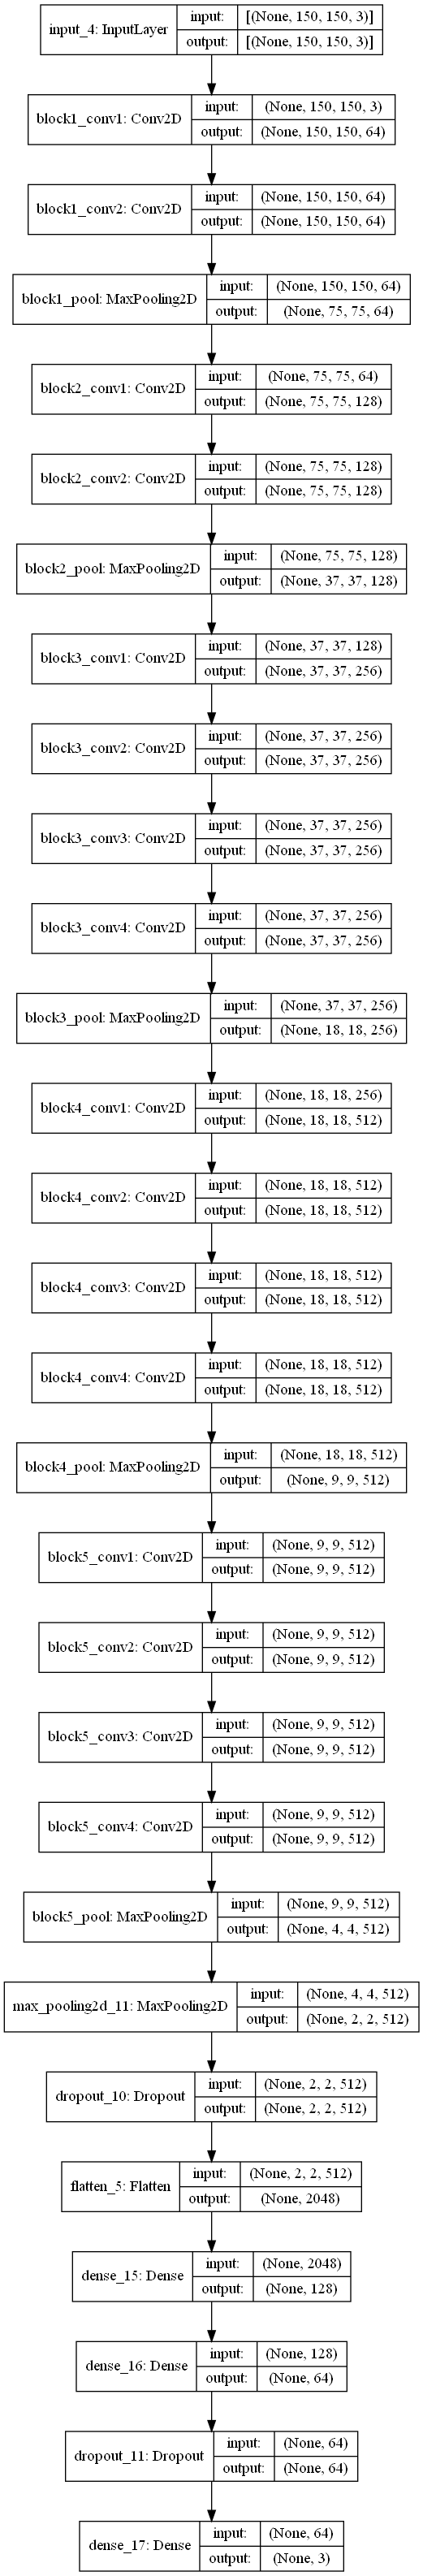

In [41]:
plot_model(model, show_shapes=True, to_file='model_vgg.png')

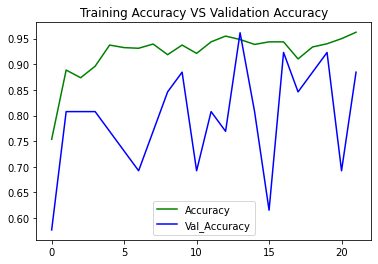

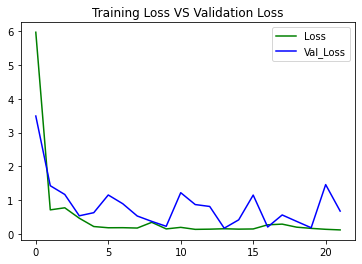

In [57]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc,'g',label='Accuracy')
plt.plot(epochs,val_acc,'b',label='Val_Accuracy')
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'g',label='Loss')
plt.plot(epochs,val_loss,'b',label='Val_Loss')
plt.title('Training Loss VS Validation Loss')
plt.legend()
plt.show()

Testing the model

In [43]:
model.evaluate(test_data)

113/113 [==============================] - 36s 320ms/step - loss: 0.3493 - accuracy: 0.9121


[0.3493269681930542, 0.9121245741844177]

Predicting and plotting confusion matrix

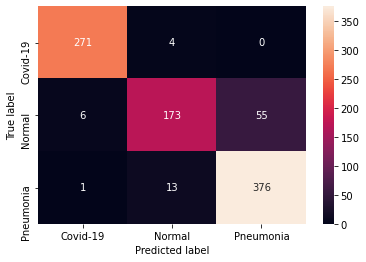

In [44]:
predictions = model.predict(test_data)  
predict_classes = np.argmax(predictions, axis = 1)
cm = confusion_matrix(test_data.classes, predict_classes)
f = sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Covid-19', 'Normal', 'Pneumonia'], yticklabels=['Covid-19', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_pretrained.png')

Classification report

In [45]:
classes = list(train_data.class_indices)
print(classification_report(test_data.classes, predict_classes, target_names=classes))

              precision    recall  f1-score   support

     COVID19       0.97      0.99      0.98       275
      NORMAL       0.91      0.74      0.82       234
   PNEUMONIA       0.87      0.96      0.92       390

    accuracy                           0.91       899
   macro avg       0.92      0.90      0.90       899
weighted avg       0.91      0.91      0.91       899



Model from scratch

In [46]:
model1 = Sequential()
model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D((2, 2)))

model1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D((2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())

model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(3, activation='softmax'))

opti = Adam(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opti)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 17, 17, 64)       

Plotting the model and the graphs

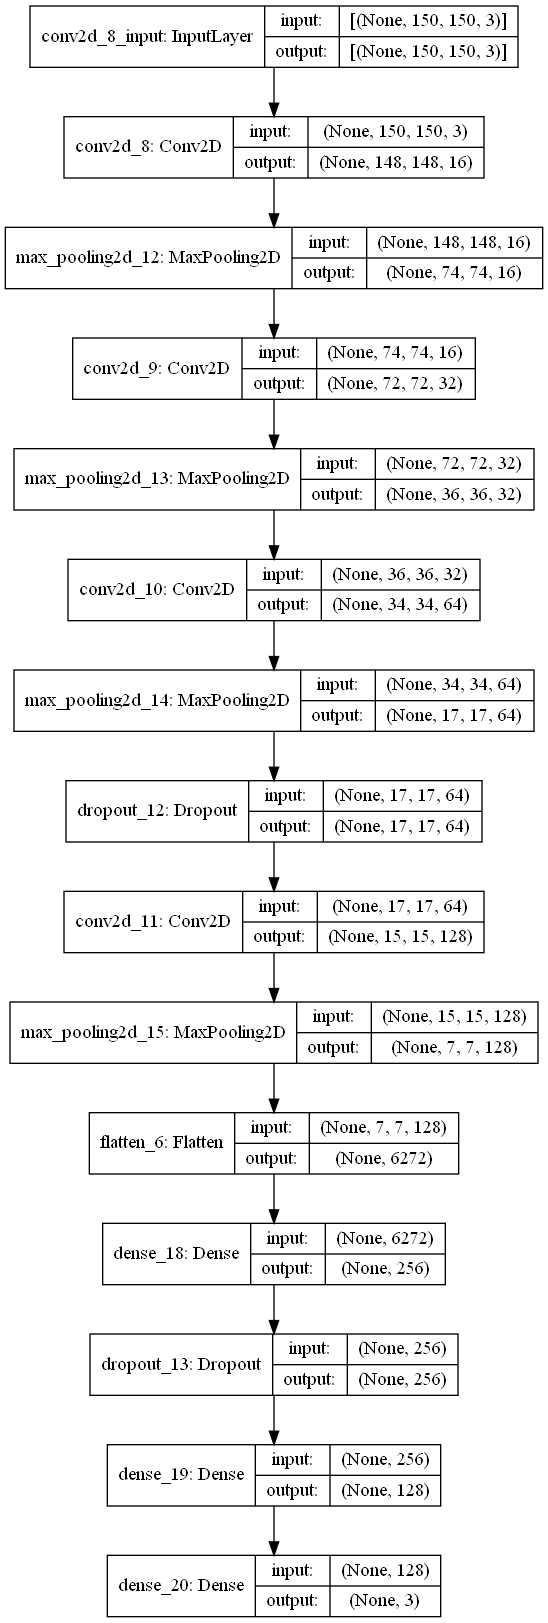

In [47]:
plot_model(model1, show_shapes=True, to_file='model_scratch.png')

Training the model

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
hist1 = model1.fit(x=train_data, epochs=30, batch_size=8, validation_data=val_data, callbacks=early_stop, steps_per_epoch=100)

Epoch 1/30
100/100 [==============================] - 10s 97ms/step - loss: 9.2840 - accuracy: 0.5213 - val_loss: 1.0673 - val_accuracy: 0.3462
Epoch 2/30
100/100 [==============================] - 8s 83ms/step - loss: 1.0092 - accuracy: 0.6488 - val_loss: 0.7778 - val_accuracy: 0.6538
Epoch 3/30
100/100 [==============================] - 9s 92ms/step - loss: 0.7187 - accuracy: 0.7113 - val_loss: 0.8555 - val_accuracy: 0.7308
Epoch 4/30
100/100 [==============================] - 9s 92ms/step - loss: 0.9088 - accuracy: 0.6463 - val_loss: 1.0441 - val_accuracy: 0.3077
Epoch 5/30
100/100 [==============================] - 8s 84ms/step - loss: 0.7409 - accuracy: 0.7000 - val_loss: 1.5354 - val_accuracy: 0.5769
Epoch 6/30
100/100 [==============================] - 8s 81ms/step - loss: 0.5872 - accuracy: 0.7513 - val_loss: 0.9011 - val_accuracy: 0.7308
Epoch 7/30
100/100 [==============================] - 8s 81ms/step - loss: 0.4268 - accuracy: 0.8213 - val_loss: 0.5863 - val_accuracy: 0.692

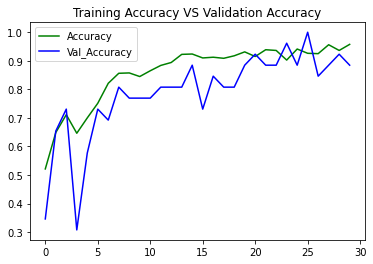

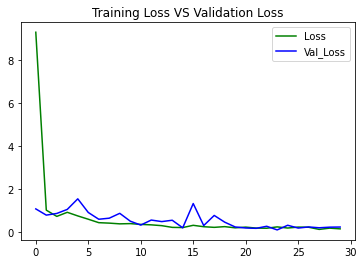

In [58]:
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc,'g',label='Accuracy')
plt.plot(epochs,val_acc,'b',label='Val_Accuracy')
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'g',label='Loss')
plt.plot(epochs,val_loss,'b',label='Val_Loss')
plt.title('Training Loss VS Validation Loss')
plt.legend()
plt.show()

Testing the model

In [50]:
model1.evaluate(test_data)

113/113 [==============================] - 7s 61ms/step - loss: 0.6983 - accuracy: 0.8242


[0.698307991027832, 0.8242491483688354]

Prediction and plotting confusion matrix

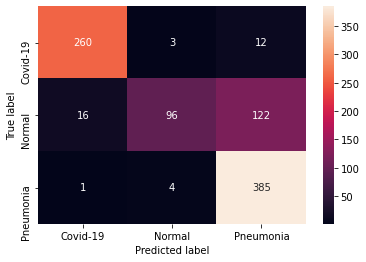

In [51]:
predictions1 = model1.predict(test_data)  
predict_classes1 = np.argmax(predictions1, axis = 1)
cm = confusion_matrix(test_data.classes, predict_classes1)
f = sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Covid-19', 'Normal', 'Pneumonia'], yticklabels=['Covid-19', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('confusion_scratch.png')

Classification report

In [52]:
classes = list(train_data.class_indices)
print(classification_report(test_data.classes, predict_classes1, target_names=classes))

              precision    recall  f1-score   support

     COVID19       0.94      0.95      0.94       275
      NORMAL       0.93      0.41      0.57       234
   PNEUMONIA       0.74      0.99      0.85       390

    accuracy                           0.82       899
   macro avg       0.87      0.78      0.79       899
weighted avg       0.85      0.82      0.80       899

